# Exploratory data analysis

Importing the necessary libraries

In [58]:
import pandas as pd
import numpy as np
import json
import random
import nltk
import re

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.probability import FreqDist


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

In [5]:
file_path = "C:/Users/Lenovo/Desktop/IT coding/IT project/news.json"
with open(file_path, "r") as file:
    data = json.load(file)
    
data = pd.DataFrame(data)

In [6]:
data.head()

,Category,Full_description,Title,Cleaned_texts
0,Politics,What should be sending alarm bells through the...,Here’s why Democrats should be worried about t...,sending alarm bell white house democratic circ...
1,Politics,"Italian Prime Minister Giorgia Meloni, center,...",Opinion: What 2022’s elections taught me about...,italian prime minister giorgia meloni center f...
2,Politics,CNN —Most people don’t want to work into their...,"The consequences of old, powerful politicians ...",people want work powerful washington refuse le...
3,Politics,CNN —After the attack on the US Capitol on Jan...,Opinion: A dangerous trend for election disinf...,attack u capitol january tech company cracked ...
4,Politics,“Governors are uniquely positioned to take thi...,Bipartisan governors challenge Americans to di...,governor uniquely positioned take actually get...


Exploratory Data Analysis *(EDA)* serves the purpose of uncovering patterns and discernible structures within the dataset. This crucial step is particularly insightful for the subsequent classification process.

A deeper understanding of the data acquired through EDA enables a more aware interpretation of the results obtained later on. The analysis is divided into the following steps:

- **General inspection**
- **Term frequency analysis**
- **Feature extraction**
- **Cluster**

## General Inspection

The dataset of course does not present any missing values since the webscraping process already took take of this issue. 

In [7]:
missing_values_count = data.isnull().sum()
print(missing_values_count)

Category            0
Full_description    0
Title               0
Cleaned_texts       0
dtype: int64


In [8]:
print("There are {} observations and {} features in this dataset. \n".format(data.shape[0], data.shape[1]))

print("There are {} categories in the dataset which are {}... \n".format(len(data.Category.unique()),
                                                                           ", ".join(data.Category.unique())))

There are 1165 observations and 4 features in this dataset. 

There are 4 categories in the dataset which are Politics, Business, Health, Entertainment... 



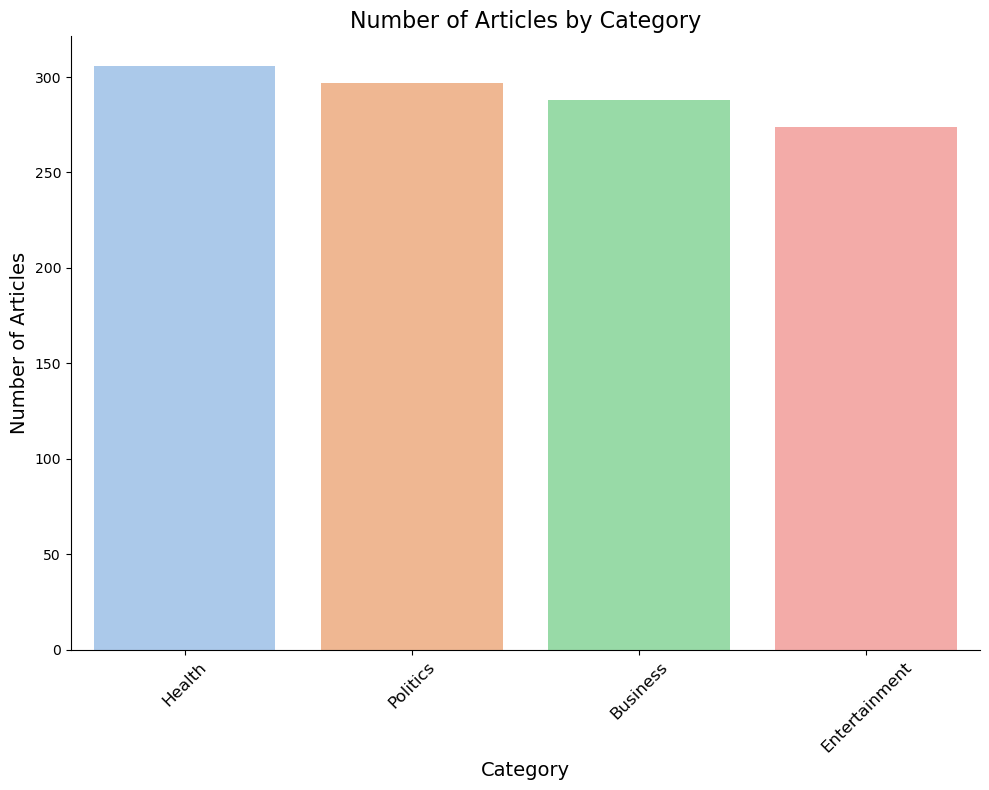

In [9]:
category_counts = data['Category'].value_counts()
colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 8))  # Set the figure size
sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors)

plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.title('Number of Articles by Category', fontsize=16)

plt.xticks(rotation=45, fontsize=12)

sns.despine()

plt.tight_layout()
plt.show()

As anticipated, the texts are uniformly distributed across categories. This even distribution results from the scraping process, where I downloaded an equal number of URLs for each category. Any minor discrepancies that may exist can likely be attributed to the nuances of the article retrieval process using the __Article()__ method. These differences, although present, are so negligible that they can be considered inconsequential.

## Term frequency analysis

In the context of Exploratory Data Analysis (EDA), Term Frequency Analysis involves a meticulous examination of the frequency of each term or word within the dataset. My particular interest lay in uncovering potential differences across categories, specifically investigating whether some categories exhibited longer texts than others.

To illustrate the utility of this analysis, consider that if a particular category consistently showed statistically significant longer texts, it could serve as a distinguishing factor for the classifier. This insight aids the classifier in recognizing that specific category more easily than others.

It's important to note that this step is executed on the original text. Despite the ultimate classification relying on the cleaned version, analyzing the original structure is essential and the preceding steps have revealed that the remaining words are uniformly distributed across categories. The removal of characters not contributing to word content, as performed by the **remove_special_characters** function, ensures that the subsequent Term Frequency Analysis focuses on meaningful linguistic elements, providing valuable insights into the dataset's inherent structure.

In [10]:
def remove_special_characters(text):
    cleaned_text = text.replace('\n', ' ')
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)

    return cleaned_text

The below lines of code create another dataframe to keep the original as clean as possible and calculate the number of words in each cleaned text. Finally, the DataFrame is filtered to include only those rows where the 'Word_count' is greater than or equal to 100. This step ensures that only texts with a substantial number of words (at least 100) are retained in the analysis.

In [11]:
data_EDA = pd.concat([data['Full_description'], data['Category']], axis=1)
data_EDA['Remove_special_characters'] = data_EDA['Full_description'].apply(remove_special_characters)

The subsequent code groups the 'Removal_special_characters' by category, calculating both word count and sentence length for each row. It then illustrates the distribution of words and sentence length within each category.

In [12]:
data_EDA['Word_count'] = data_EDA['Remove_special_characters'].apply(lambda text: len(word_tokenize(text)))
data_EDA = data_EDA[data_EDA['Word_count'] >= 100]
data_EDA.head()

,Full_description,Category,Remove_special_characters,Word_count
1,"Italian Prime Minister Giorgia Meloni, center,...",Politics,Italian Prime Minister Giorgia Meloni center f...,108
2,CNN —Most people don’t want to work into their...,Politics,CNN Most people dont want to work into their 8...,106
3,CNN —After the attack on the US Capitol on Jan...,Politics,CNN After the attack on the US Capitol on Janu...,116
5,New York CNN —As threats to democracy become i...,Politics,New York CNN As threats to democracy become in...,104
7,CNN —Millions of people will sit down at the T...,Politics,CNN Millions of people will sit down at the Th...,115


In [13]:
category_counts_words = data_EDA.groupby('Category').size().reset_index(name='Count')
print(category_counts)

Category
Health           306
Politics         297
Business         288
Entertainment    274
Name: count, dtype: int64


In [14]:
data_EDA['Sentence_len'] = data_EDA['Remove_special_characters'].apply(len)
data_EDA.head()

,Full_description,Category,Remove_special_characters,Word_count,Sentence_len
1,"Italian Prime Minister Giorgia Meloni, center,...",Politics,Italian Prime Minister Giorgia Meloni center f...,108,731
2,CNN —Most people don’t want to work into their...,Politics,CNN Most people dont want to work into their 8...,106,604
3,CNN —After the attack on the US Capitol on Jan...,Politics,CNN After the attack on the US Capitol on Janu...,116,719
5,New York CNN —As threats to democracy become i...,Politics,New York CNN As threats to democracy become in...,104,689
7,CNN —Millions of people will sit down at the T...,Politics,CNN Millions of people will sit down at the Th...,115,662


In [15]:
category_sentence_len = data_EDA.groupby('Category')['Sentence_len'].mean().reset_index(name='Average_Sentence_len')
print(category_sentence_len)

        Category  Average_Sentence_len
0       Business            716.121827
1  Entertainment            714.853107
2         Health            732.017316
3       Politics            713.832487


In [16]:
category_summary = data_EDA.groupby("Category")
category_summary.describe().head()

Word_count                                                     \
                   count        mean        std    min    25%    50%    75%   
Category                                                                      
Business           197.0  117.913706  13.420882  100.0  107.0  115.0  126.0   
Entertainment      177.0  119.785311  36.927281  100.0  105.0  113.0  123.0   
Health             231.0  120.333333  15.752065  100.0  108.0  117.0  129.0   
Politics           197.0  116.928934  12.796884  100.0  106.0  115.0  123.0   

                     Sentence_len                                        \
                 max        count        mean         std    min    25%   
Category                                                                  
Business       162.0        197.0  716.121827   91.159120  533.0  653.0   
Entertainment  528.0        177.0  714.853107  291.260624  532.0  621.0   
Health         163.0        231.0  732.017316  106.664609  536.0  656.0   
Politics       172.0        197.0  713.832487   85.466889  563.0  651.0   

                                     
                 50%    75%     max  
Category                             
Business       702.0  768.0   998.0  
Entertainment  665.0  730.0  3968.0  
Health         706.0  803.5  1081.0  
Politics       698.0  767.0  1087.0

The results obtained so far do not indicate substantial differences among the four categories. The noteworthy observation is that the 'Health' category tends to have higher values for both word counts and sentence lengths. 

However, it is essential to highlight that merely considering averages may oversimplify the analysis. Notably, categories such as 'Entertainment' and 'Health' demonstrate higher variance, signifying more significant fluctuations around the mean. To gain a clearer understanding of this variability, a boxplot can be a useful visualization tool.

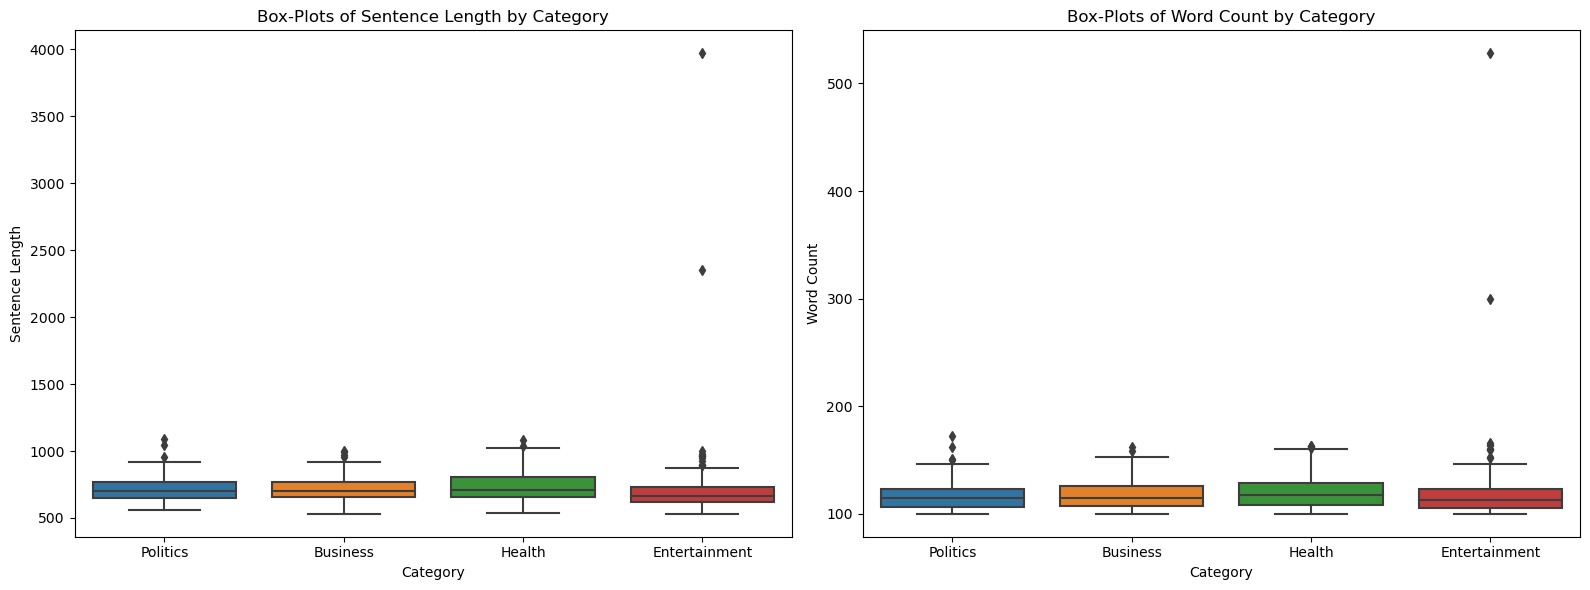

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x="Category", y="Sentence_len", data=data_EDA, ax=axes[0])
axes[0].set_title("Box-Plots of Sentence Length by Category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Sentence Length")

sns.boxplot(x="Category", y="Word_count", data=data_EDA, ax=axes[1])
axes[1].set_title("Box-Plots of Word Count by Category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Word Count")

plt.tight_layout()  
plt.show()

As predictable, the actual distribution was obscured by outliers, which were easily identified in the previous table, category_summary. To mitigate this issue, I employed the DBSCAN algorithm to detect and remove outliers from the data. Subsequently, I generated a new boxplot to visualize the refined distribution, providing a clearer representation of the data without the influence of outliers.

In [18]:
words_count = data_EDA.iloc[:, 3].values.reshape(-1, 1)
sentence_len = data_EDA.iloc[:, 4].values.reshape(-1, 1)

In [19]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(sentence_len)
outliers = (dbscan.labels_ == -1)
outliers_len = data_EDA[~outliers]

In [20]:
len(outliers_len)

210

In [21]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(words_count)
outliers = (dbscan.labels_ == -1)
outliers_count = data_EDA[~outliers]

In [22]:
len(outliers_count)

651

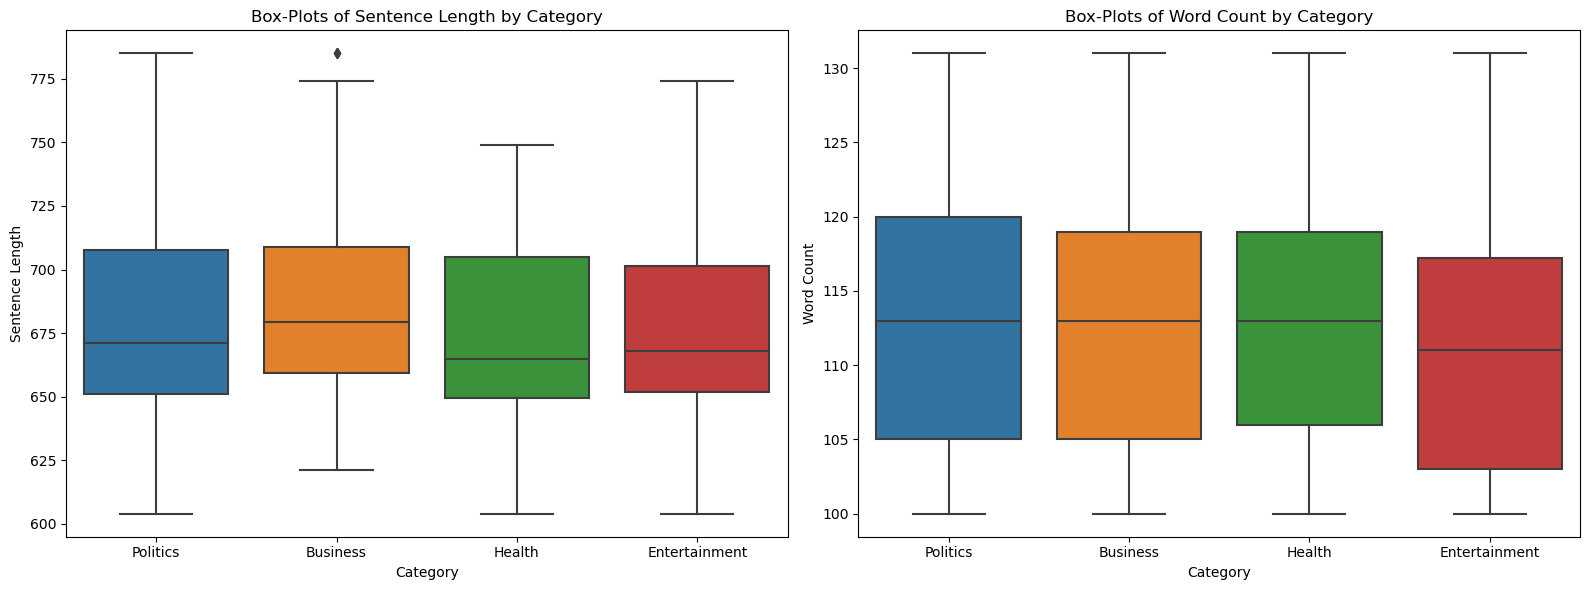

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x="Category", y="Sentence_len", data=outliers_len, ax=axes[0])
axes[0].set_title("Box-Plots of Sentence Length by Category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Sentence Length")

sns.boxplot(x="Category", y="Word_count", data=outliers_count, ax=axes[1])
axes[1].set_title("Box-Plots of Word Count by Category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Word Count")

plt.tight_layout() 
plt.show()

At this point, it can be concluded that the term frequency analysis has yielded a discernible result: there is no significant difference among the categories, both in terms of word counts and sentence lengths. The refined analysis, incorporating outlier detection through the DBSCAN algorithm, has provided a clearer and more accurate portrayal of the distribution across categories.

Out of curiosity, I experimented with the Python library "**Readability**," aiming to assess the complexity of text interpretation for humans. 

Using this library, particularly the .gunning_fog() method, I computed the __Gunning Fog__ index. In linguistics, this index serves as a readability test for English writing, estimating the years of formal education needed for a person to understand the text on the first reading. For example, a fog index of 12 suggests a reading level equivalent to that of a United States high school senior (around 18 years old). The index is a weighted average of the number of words per sentence and the number of long words per word.

In [24]:
from readability import Readability

for index, row in data_EDA.iterrows():
    text = row['Remove_special_characters']
    r = Readability(text)
    gf = r.gunning_fog()
    data_EDA.at[index, 'Gf_Score'] = gf.score

In [25]:
data_EDA.head()

,Full_description,Category,Remove_special_characters,Word_count,Sentence_len,Gf_Score
1,"Italian Prime Minister Giorgia Meloni, center,...",Politics,Italian Prime Minister Giorgia Meloni center f...,108,731,47.644444
2,CNN —Most people don’t want to work into their...,Politics,CNN Most people dont want to work into their 8...,106,604,47.305660
3,CNN —After the attack on the US Capitol on Jan...,Politics,CNN After the attack on the US Capitol on Janu...,116,719,54.675862
5,New York CNN —As threats to democracy become i...,Politics,New York CNN As threats to democracy become in...,104,689,50.830769
7,CNN —Millions of people will sit down at the T...,Politics,CNN Millions of people will sit down at the Th...,115,662,50.521739


In [26]:
category_gf = data_EDA.groupby('Category')['Gf_Score'].mean().reset_index(name='Average_Gf')
print(category_gf)

        Category  Average_Gf
0       Business   53.266957
1  Entertainment   52.409014
2         Health   54.078197
3       Politics   52.530865


The average Gunning Fog index remains consistent across all categories, indicating a homogeneous level of difficulty in terms of readability.

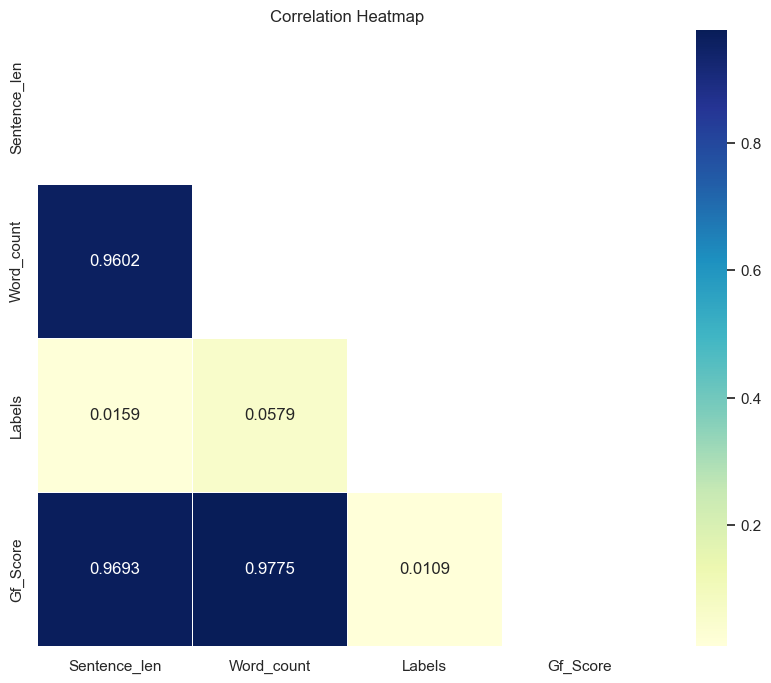

In [27]:
data_EDA['Labels'] = data_EDA['Category'].factorize()[0]
correlation = data_EDA[['Sentence_len', 'Word_count', 'Labels', 'Gf_Score']].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
sns.set_style("white")

heatmap = sns.heatmap(correlation, annot=True, fmt='.4f', cmap='YlGnBu', linewidths=.6, mask=mask)
plt.title('Correlation Heatmap')
plt.show()

## Feature extraction

Feature extraction in natural language processing is aimed at distilling meaningful information from raw text data. 

The primary goal is to transform textual content into a numerical representation understandable by machine learning algorithms. This process captures essential linguistic patterns, semantic information, and other relevant characteristics inherent in the text. 

Well-chosen features play a pivotal role in enhancing the performance of machine learning models, contributing to their ability to make accurate predictions based on input data.


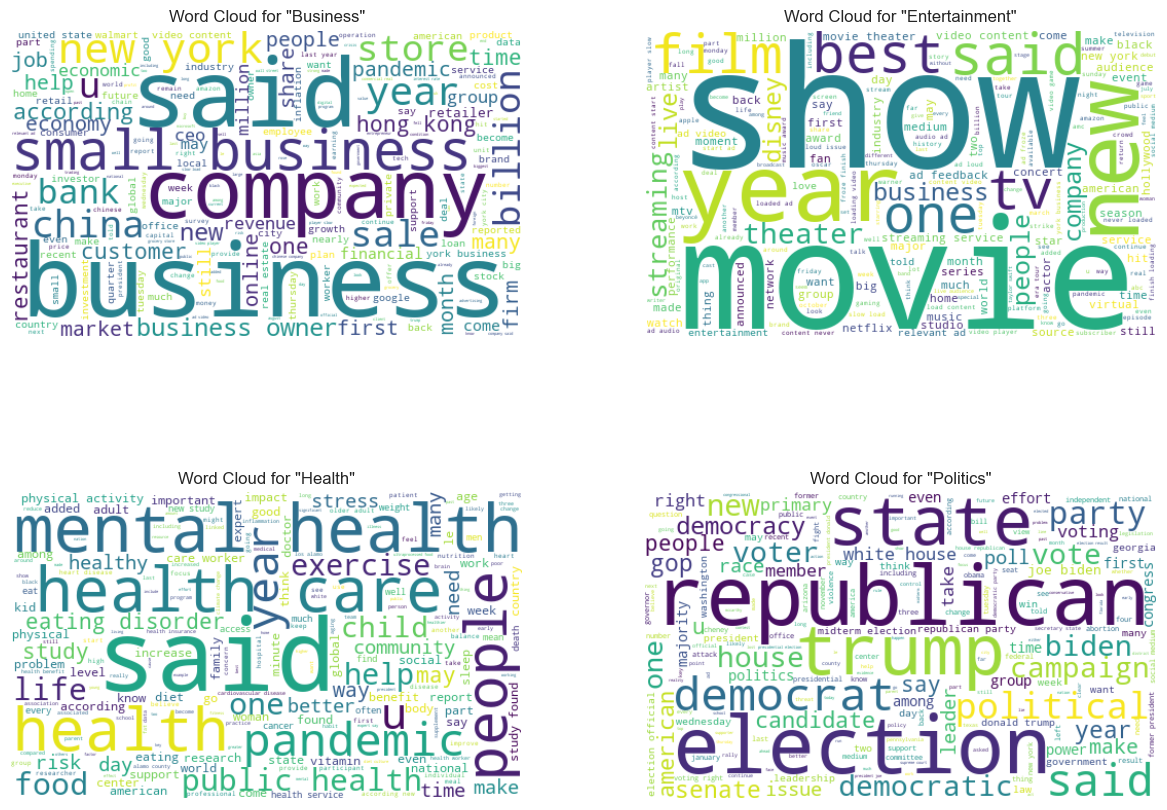

In [28]:
from wordcloud import WordCloud

wordclouds = {}
grouped = data.groupby('Category')
num_categories = len(grouped)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)  

for i, (category, group) in enumerate(grouped):
    category_text = ' '.join(group['Cleaned_texts'])  
    wordcloud = WordCloud(width=500, height=300, background_color='white').generate(category_text)

    row = i // 2
    col = i % 2

    subplot = axes[row, col]  

    subplot.imshow(wordcloud, interpolation='bilinear')
    subplot.set_title(f'Word Cloud for "{category}"')
    subplot.axis('off')

plt.show()

In _Natural Language Processing_ (NLP), features can encompass individual words, sets of words, or even focus on the most significant ones. To discern the most effective features for classification, various strategies can be employed. 

I opted to utilize frequency tracking as a means of selection. Initially, I conducted an N-grams analysis, considering uni-grams, bi-grams, and tri-grams, and compared their distributions to identify which linguistic structures are more representative of each category. 

N-grams analysis is a technique in natural language processing (NLP) that involves examining and extracting contiguous sequences of n items (typically words or tokens) from a given text:
- Uni-grams (1-grams): single words are extracted from the text independently.
- Bi-grams (2-grams): sequential pairs of words are extracted.
- Tri-grams (3-grams): consecutive sequences of three words are extracted.

N-grams help capture local patterns and relationships between words in a given context. It provides insight into how words are used together helping to predict the probability of the next word in a sequence given the previous ones.

The function **n_grams_per_category** was instrumental in computing the frequency distribution of n-grams for each category within a given text dataset. It tokenizes the text, extracts N-grams, and counts their occurrences for each category.

In [32]:
def n_grams_per_category(texts, n):
    category_n_gram_freq = {}

    for category, group in texts.groupby('Category'):
        all_n_grams = []

        for text in group['Cleaned_texts']:
            tokens = nltk.word_tokenize(text)
            n_grams_list = list(ngrams(tokens, n))
            all_n_grams.extend(n_grams_list)

        n_gram_freq = FreqDist(all_n_grams)
        category_n_gram_freq[category] = n_gram_freq

    return category_n_gram_freq

In [33]:
uni_grams = n_grams_per_category(data, 1)
bi_grams = n_grams_per_category(data, 2)
tri_grams = n_grams_per_category(data, 3)

In [ ]:
def plot_n_grams(category_n_gram_freq, top_n, n):
    colors = ['lightgreen', 'lightblue', 'yellow', 'purple', 'orange', 'pink']
    index = random.randint(0, len(colors)-1)

    plt.figure(figsize=(16, 10))
    subplots_per_category = len(category_n_gram_freq)

    for idx, (category, n_gram_freq) in enumerate(category_n_gram_freq.items(), 1):
        top_n_grams = n_gram_freq.most_common(top_n)

        n_gram_labels = [' '.join(n_gram) for n_gram, freq in top_n_grams]
        n_gram_freqs = [freq for n_gram, freq in top_n_grams]

        plt.subplot(2, 2, idx)

        plt.barh(n_gram_labels, n_gram_freqs, color=colors[index])
        plt.xlabel('Frequency')
        plt.ylabel('1-gram' if n == 1 else f'{n}-grams')
        plt.title(f'Top {top_n} {n}-gram in "{category}" Category' if n == 1 else f'Top {top_n} {n}-grams in "{category}" Category')
        plt.gca().invert_yaxis()
        plt.grid(True)
        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.tight_layout()
    plt.show()

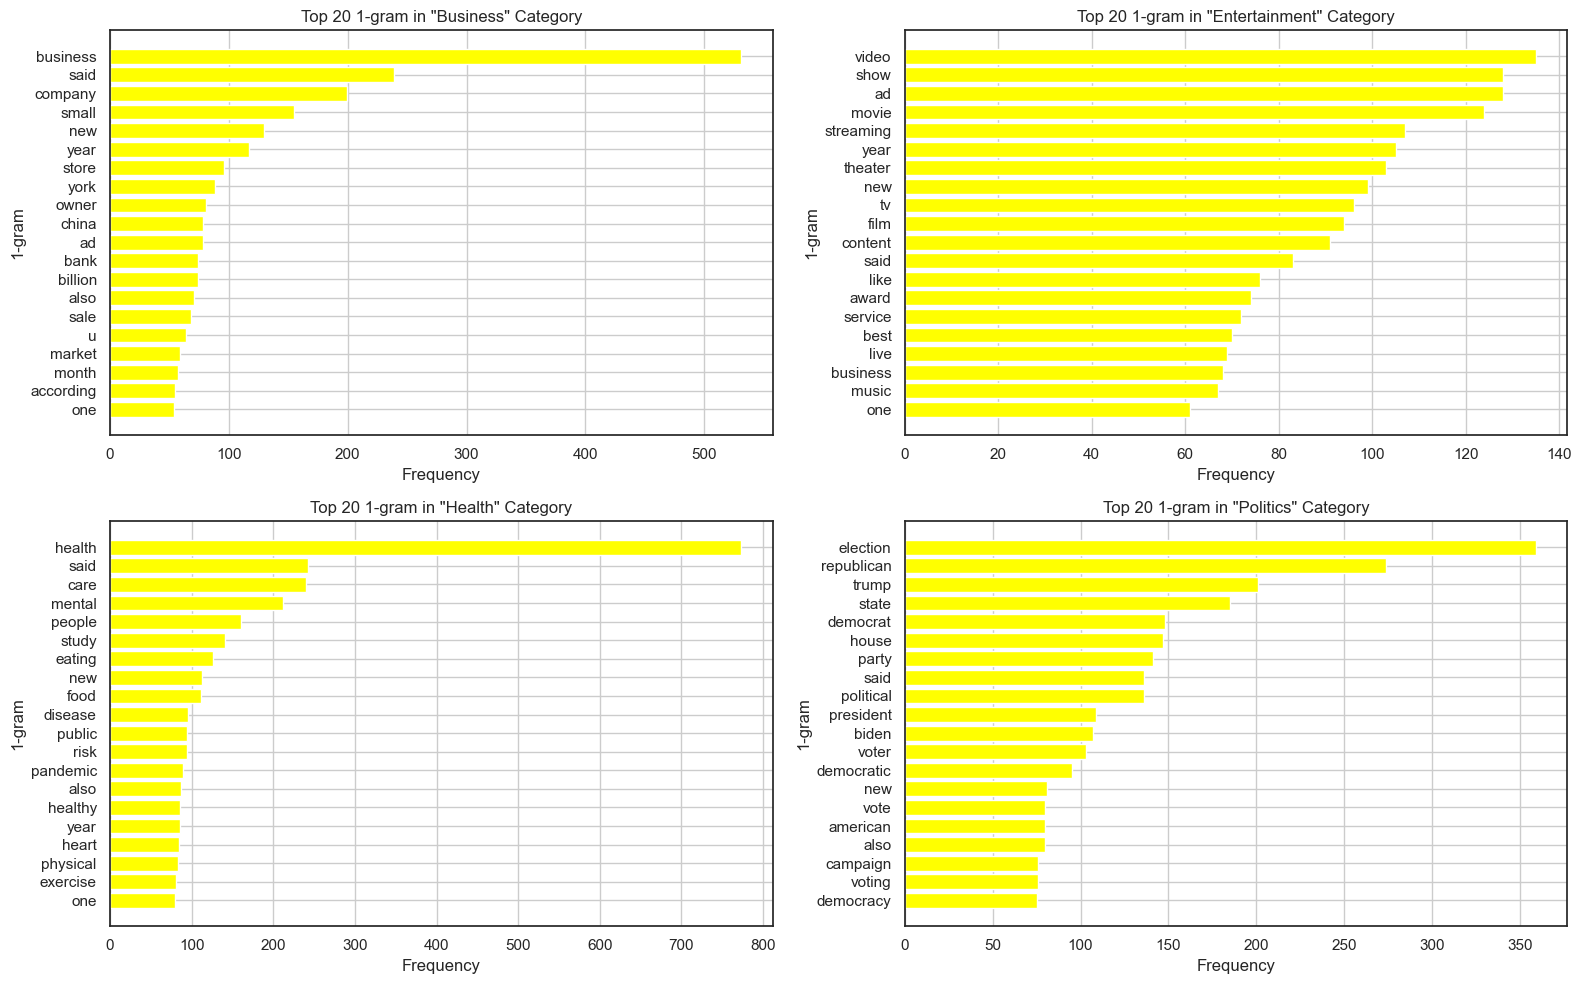

In [ ]:
plot_n_grams(uni_grams, 20, 1)

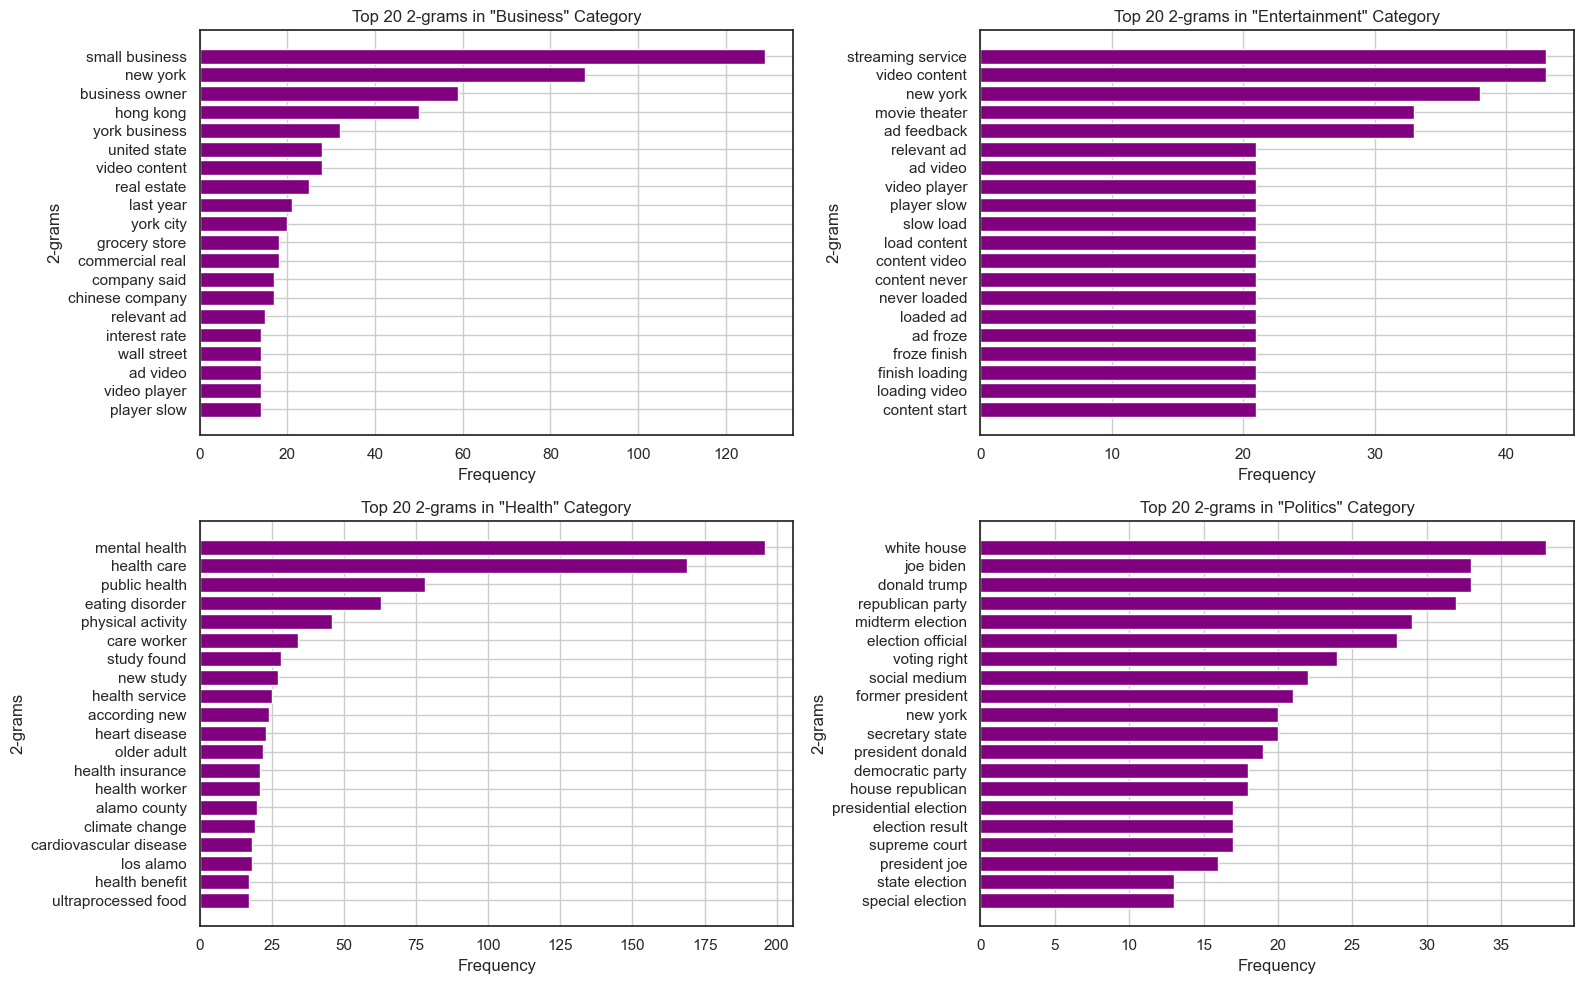

In [ ]:
plot_n_grams(bi_grams, 20, 2)

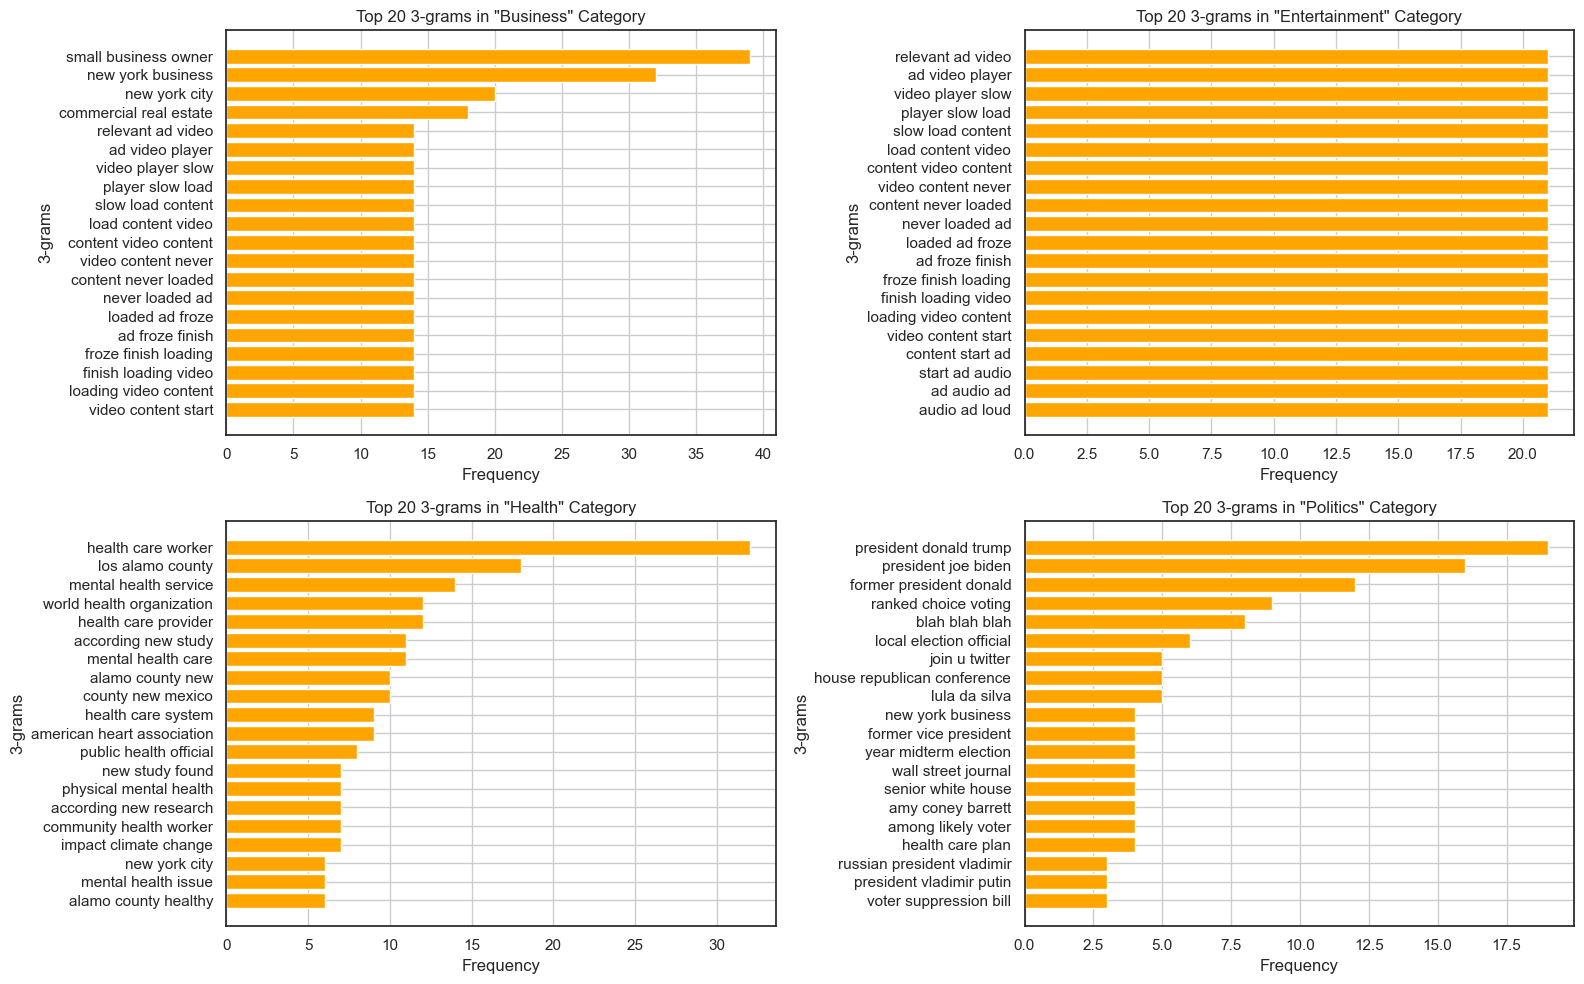

In [ ]:
plot_n_grams(tri_grams, 20, 3)

In [35]:
tokenized_data = data['Cleaned_texts'].apply(word_tokenize)
unique_words_set = set(word for sentence in tokenized_data for word in sentence)
num_unique_words = len(unique_words_set)

print(f"Number of unique words: {num_unique_words}")

Number of unique words: 10994


It is worth asking how many features should be selected in order to perform a good classification. Indeed the entire vocabulary has 10994 unique words but to avoid overfitting and time complexity it is better to select just the most significant ones. The following steps try to do so. 

**TfidfVectorizer**: it is a class in scikit-learn that is used to convert a collection of raw documents to a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

**max_features**: it specifies the maximum number of unique features (words or n-grams) to consider in the TF-IDF matrix.

**ngram_range=()**: it determines the range of n-grams to be considered. In this case, it includes unigrams, bigrams, and trigrams.

So, the overall purpose of this code is to create a TF-IDF vectorizer considering unigrams, bigrams, and trigrams from the input text data. 

The matrix has 1165 rows. Each row corresponds to a document in the dataset (**data['Cleaned_texts']**). Each column represents a unique feature (word or n-gram) selected by the TF-IDF vectorizer. So, for each document, there is a representation in a dimensional space, where each dimension corresponds to the importance of a specific feature in that document based on its TF-IDF score. 

In [44]:
vectorizer = TfidfVectorizer(max_features=10994, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(data['Cleaned_texts'])

The following code visually inspects the sparsity of a random sample of 100 features from the TF-IDF matrix of the n-grams, providing an overview of how many values are non-zero (white) or zero (black) in that sample. This can be helpful for understanding the density of information in the TF-IDF matrix.

Text(0.5, 1.0, 'Sparse Matrix Sample')

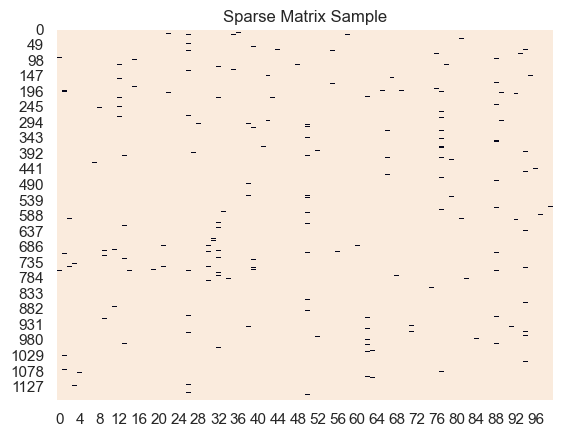

In [39]:
sns.heatmap(vectorizer.todense()[:, np.random.randint(0, vectorizer.shape[1], 100)] == 0, vmin= 0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [61]:
feature_names = vectorizer.get_feature_names_out()

y = data['Category'].factorize()[0]
chi2_stat, p_values = chi2(tfidf_matrix, y)
p_value_limit = 0.95

# Get selected features
selected_features = [feature_names[i] for i, p_value in enumerate(p_values) if p_value < p_value_limit]

len(selected_features)

8587

In [62]:
selected_features_df = pd.DataFrame({'Selected Features': selected_features})
selected_features_df.to_csv('selected_features.csv', index=False)

The features selected have been saved and so they can be used for the classification in the next steps. 

## Cluster

I had a concern regarding the potential sparsity of the four categories in the dataset. I considered that if a category is not well-clustered in terms of textual data, as encoded in a TF-IDF matrix, the classifier might face challenges in recognizing and potentially exhibit bias toward that category.

To investigate this, I employed a KMeans clustering algorithm to generate four clusters (corresponding to the four categories) from the TF-IDF matrix. The objective was to observe how the textual data from each category would be grouped together. The goal was to determine whether the four categories were easily distinguishable or not.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Cleaned_texts'])
tfidf_matrix.get_shape()

(1165, 136112)

I employed the KMeans implementation from the sklearn.cluster library to create four clusters. Subsequently, I associated each document's category with the cluster assignments made by the algorithm in the dataframe **cluster_df**. This step aimed to assess the alignment between the actual categories and the clusters assigned by the algorithm.

In [ ]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
k = 4  

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
kmeans.fit(cosine_sim_matrix)
data['Cluster'] = kmeans.labels_

cluster_df = pd.concat([data['Category'], data['Cluster']], axis=1)

c:\Users\Lenovo\anaconda3\envs\mina\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Lenovo\anaconda3\envs\mina\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [ ]:
cluster_df.head()

,Category,Cluster
0,Politics,1
1,Politics,0
2,Politics,0
3,Politics,1
4,Politics,1


The next step aims to analyze the distribution of categories within each cluster. The following code provides the normalized frequencies of each category within each cluster, the result is stored in the dataframe **category_frequencies**. 

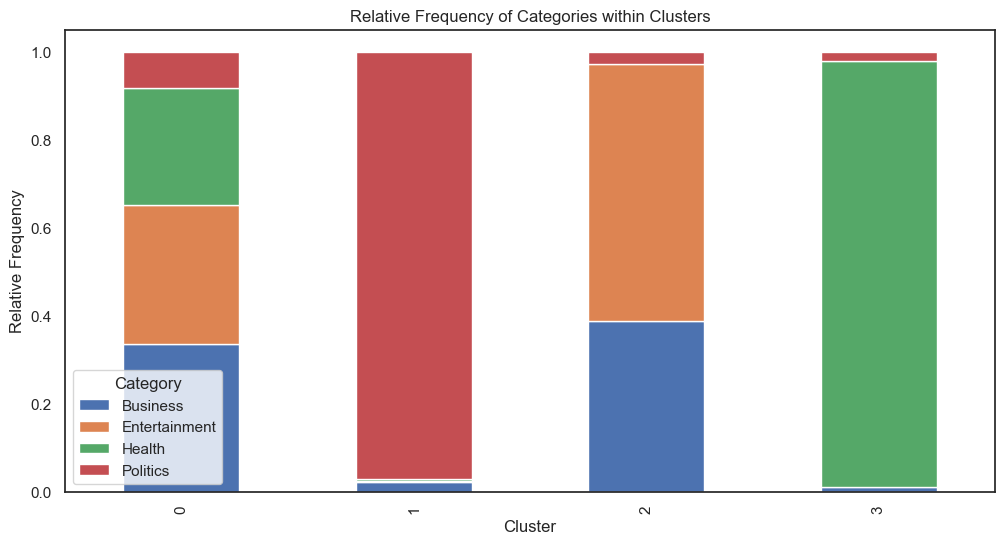

In [ ]:
category_counts = cluster_df.groupby(['Cluster', 'Category']).size().unstack()
category_frequencies = category_counts.div(category_counts.sum(axis=1), axis=0)

category_frequencies.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Relative Frequency of Categories within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Relative Frequency')
plt.legend(title='Category')

plt.show()

Based on the bar plot, it is evident that the classification task may be more straightforward for the 'Health' and 'Politics' categories. The textual data for these categories appears to be well-separated, suggesting distinct clusters in the visualization. In contrast, the 'Entertainment' and 'Business' categories show less clear separation, indicating that the classifier might face challenges in distinguishing between these two categories. 

The following code performs dimensionality reduction using t-SNE, creating a 2D visualization of the TF-IDF matrix. It then uses a scatter plot to display the data points with colors representing their assigned K-Means clusters. The colorbar provides a key for interpreting the clusters in the visualization.

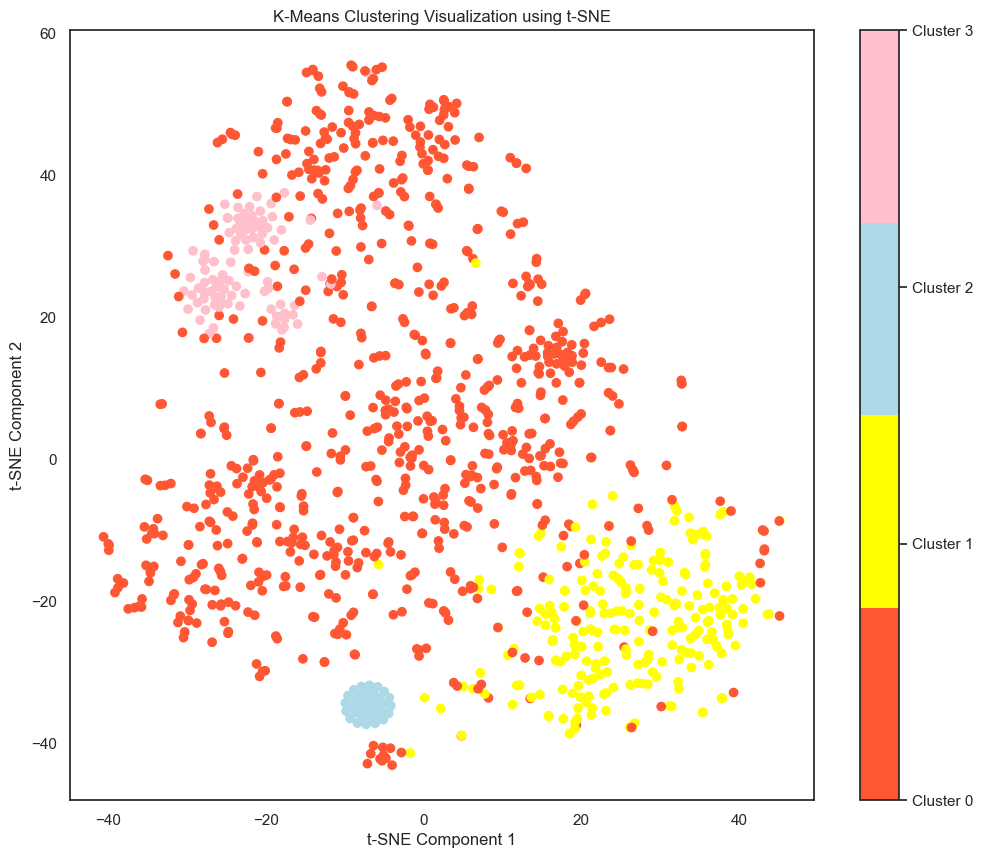

In [ ]:
cluster_assignments = kmeans.labels_
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(tfidf_df)

cmap = ListedColormap(['#FF5733', 'yellow', 'lightblue', 'pink'])  # Customize the colors as needed

plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_assignments, cmap=cmap)
plt.title('K-Means Clustering Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

cbar = plt.colorbar(scatter, ticks=range(len(set(cluster_assignments))))
cbar.set_ticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])  # Customize cluster labels

plt.show()

The t-SNE visualization reinforces the observations made earlier, highlighting distinct patterns in the clustering of data points. Specifically, clusters one and three appear to have denser concentrations of data points, emphasizing a more cohesive structure within these clusters. On the other hand, the lightblue and yellow points are more dispersed, indicating a greater degree of variability or overlap in the feature space.

Various adjustments can be considered to enhance the classification process. These include obtaining more news articles from the 'Business' and 'Entertainment' categories through additional scraping, scrutinizing the accuracy of labeling, and exploring the incorporation of additional features like publication date, author, keywords, and title, if available. The implementation of these adjustments will be contingent on the classification model facing challenges in achieving its objectives.